<a href="https://colab.research.google.com/github/Nick1467/CLS-/blob/main/CLS%E4%B8%8A%E8%A8%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# raw scipt version


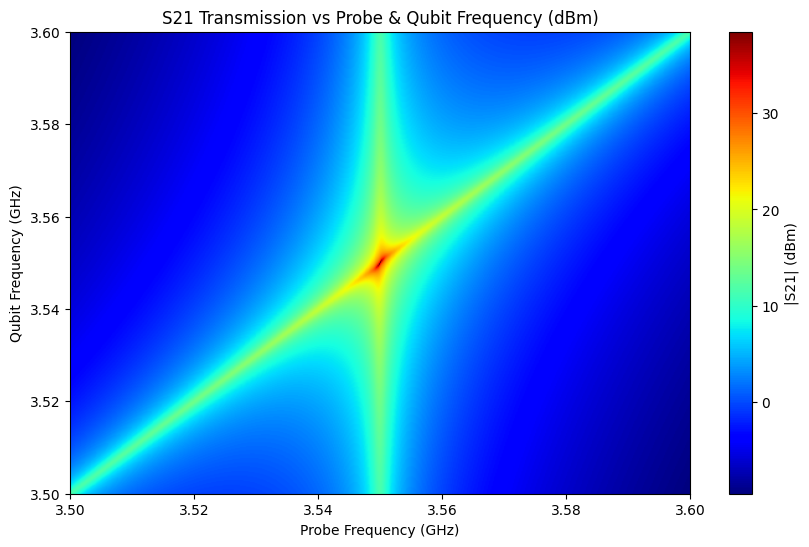

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve

# ====== System Setup ======
def build_full_hamiltonian(omega_1,  omega_q, gamma_1, gamma_2):
    H = np.zeros((2, 2), dtype=complex)
    H[ 0, 0] = omega_1 - 1j * gamma_1
    H[ 1, 0] = H[ 0, 1] = + 1j*np.sqrt(gamma_1*gamma_2)
    H[1, 1] = omega_q - 1j * gamma_2
    return H


def compute_s21_map(N, H_base, probe_freqs, qubit_freqs, kappa_c_left, kappa_c_righ, mode='dBm'):
    S21_map = []

    for omega_q in qubit_freqs:
        H = H_base.copy()
        H[1, 1] = omega_q - 1j * gamma_2
        H[ 1, 0] = H[ 0, 1] = + 1j*np.sqrt(gamma_1*gamma_2)

        S21 = []
        for omega in probe_freqs:
            A = H - omega * np.eye(N )
            b = np.zeros(N , dtype=complex)
            b[0] = np.sqrt(kappa_c_left)
            x = solve(A, b)
            s21 = np.sqrt(kappa_c_right) * x[N - 1]

            if mode == 'dBm':
                S21.append(10 * np.log10(np.abs(s21)))
            elif mode == 'linear':
                S21.append(np.abs(s21))
            elif mode == 'phase':
                S21.append(np.angle(s21))
        S21_map.append(S21)

    return np.array(S21_map)


def plot_s21_map(S21_map, probe_freqs, qubit_freqs, mode='dBm'):
    plt.figure(figsize=(10, 6))
    label = {'dBm': '|S21| (dBm)', 'linear': '|S21|', 'phase': 'Phase (rad)'}[mode]

    plt.imshow(S21_map, aspect='auto', origin='lower',
               extent=[probe_freqs[0]/1e9, probe_freqs[-1]/1e9, qubit_freqs[0]/1e9, qubit_freqs[-1]/1e9],
               cmap='jet')
    plt.colorbar(label=label)
    plt.xlabel('Probe Frequency (GHz)')
    plt.ylabel('Qubit Frequency (GHz)')
    plt.title(f'S21 Transmission vs Probe & Qubit Frequency ({mode})')
    plt.show()


# ====== Parameters ======
N =2
omega_1 = 3.55e9
gamma_1 = 5e5
gamma_2 = 5e5
qubit_freqs = np.linspace(3.5e9, 3.6e9, 500)
probe_freqs = np.linspace(3.5e9, 3.6e9, 500)
mode = 'dBm'
# ====== Create non-uniform gamma and kappa_c mapping ======
gamma_map = [8e5, 8e5]
kappa_map = [7e8, 7e8]


gamma_1 = gamma_map[0]
gamma_2 = gamma_map[1]
kappa_c_left = kappa_map[0]
kappa_c_right = kappa_map[1]

# ====== Simulation ======
H_base = build_full_hamiltonian(omega_1, qubit_freqs[0], gamma_1, gamma_2)
S21_map = compute_s21_map(N, H_base, probe_freqs, qubit_freqs, kappa_c_left, kappa_c_right, mode)
plot_s21_map(S21_map, probe_freqs, qubit_freqs, mode)


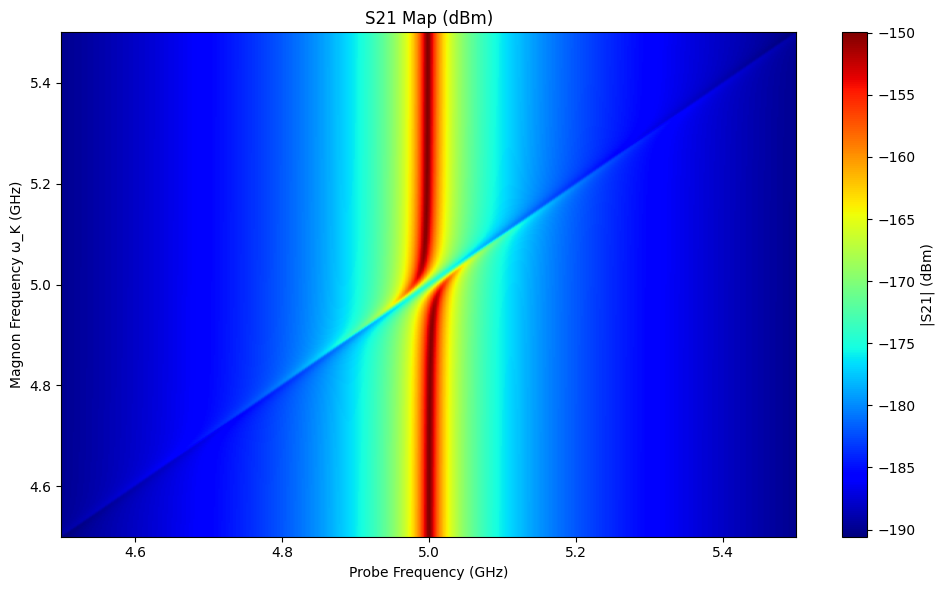

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve

# ====== 模擬參數 ======
omega_c = 2 * np.pi * 5e9      # cavity mode 頻率 (rad/s)
gamma_s = 2 * np.pi * 5e6      # cavity 模式 linewidth
delta_m = 2 * np.pi * 2e6      # magnon 本徵 linewidth
Gamma_r = 2 * np.pi * 3e6      # traveling wave 對 magnon 的徑向損耗

# 有效耦合常數（可以調為正、負以模擬吸引或排斥）
g_eff = 2 * np.pi * 20e6       # 有效耦合強度
phi = np.pi/2                        # 相位：0（排斥），π（吸引）

# 掃描頻率區間
probe_freqs = np.linspace(4.5e9, 5.5e9, 500)  # 探針頻率 ω
qubit_freqs = np.linspace(4.5e9, 5.5e9, 500)  # magnon ωK

def compute_S21_map(probe_freqs, qubit_freqs, omega_c, gamma_s, delta_m, Gamma_r, g_eff, phi= np.pi, mode='dBm'):
    S21_map = []
    for omega_K in qubit_freqs:
        S21_row = []
        for omega in probe_freqs:
            # 建立非 Hermitian Hamiltonian
            H = np.array([
                [omega_K - 1j*(delta_m + Gamma_r), g_eff * np.exp(1j * phi/2)],
                [g_eff * np.exp(-1j * phi/2), omega_c - 1j*gamma_s]
            ])
            A = H - omega * np.eye(2)
            b = np.array([0, 1.0])  # 輸入訊號從 cavity 側輸入

            x = solve(A, b)
            s21 = x[1]  # 輸出訊號在 cavity port

            if mode == 'dBm':
                S21_row.append(10 * np.log10(np.abs(s21)**2))
            elif mode == 'linear':
                S21_row.append(np.abs(s21))
            elif mode == 'phase':
                S21_row.append(np.angle(s21))
        S21_map.append(S21_row)
    return np.array(S21_map)

def plot_S21(S21_map, probe_freqs, qubit_freqs, mode='dBm'):
    plt.figure(figsize=(10, 6))
    extent = [probe_freqs[0]/1e9, probe_freqs[-1]/1e9,
              qubit_freqs[0]/1e9, qubit_freqs[-1]/1e9]
    label = {'dBm': '|S21| (dBm)', 'linear': '|S21|', 'phase': 'Phase (rad)'}[mode]
    plt.imshow(S21_map, aspect='auto', origin='lower', extent=extent, cmap='jet')
    plt.colorbar(label=label)
    plt.xlabel('Probe Frequency (GHz)')
    plt.ylabel('Magnon Frequency ω_K (GHz)')
    plt.title(f'S21 Map ({mode})')
    plt.tight_layout()
    plt.show()

# ====== 模擬執行 ======
S21_map = compute_S21_map(probe_freqs * 2 * np.pi, qubit_freqs * 2 * np.pi,
                           omega_c, gamma_s, delta_m, Gamma_r, g_eff, mode='dBm')
plot_S21(S21_map, probe_freqs, qubit_freqs, mode='dBm')

# Experiment figure

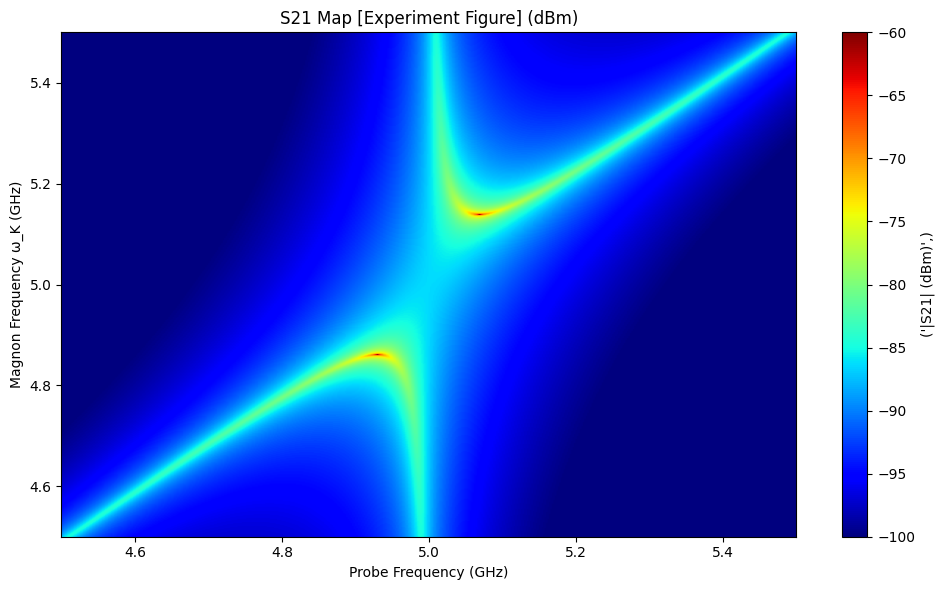

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve



def compute_S21_map(probe_freqs, qubit_freqs, omega_c, gamma_s, delta_m, Gamma_r, g_eff, phi, mode='dBm'):
    S21_map = []
    for omega_m in qubit_freqs:
        S21_row = []
        for omega in probe_freqs:
            # 建立非 Hermitian Hamiltonian
            H = np.array([
                [omega_m - 1j*(delta_m + Gamma_r), g_eff ],
                [g_eff * np.exp(-1j * phi), omega_c - 1j*(gamma_s+delta_m)]
            ])
            A = H - omega * np.eye(2)
            b = np.array([0, 1.0])  # 輸入訊號從 cavity 側輸入

            x = solve(A, b)
            s21 =  x[0]  # 輸出訊號在 cavity port

            if mode == 'dBm':
                S21_row.append(10 * np.log10(np.abs(s21)))
            elif mode == 'linear':
                S21_row.append(np.abs(s21))
            elif mode == 'phase':
                S21_row.append(np.angle(s21))
            else:
                raise ValueError("Invalid mode. Choose from 'dBm', 'linear', or 'phase'.")
        S21_map.append(S21_row)
    return np.array(S21_map)

def plot_S21(S21_map, probe_freqs, qubit_freqs, mode='dBm'):
    plt.figure(figsize=(10, 6))
    extent = [probe_freqs[0]/1e9, probe_freqs[-1]/1e9,
              qubit_freqs[0]/1e9, qubit_freqs[-1]/1e9]
    label = {'dBm': '|S21| (dBm)', 'linear': '|S21|', 'phase': 'Phase (rad)'}[mode],
    plt.imshow(S21_map, aspect='auto', origin='lower', extent=extent, cmap='jet', vmax= -60, vmin= -100,)
    plt.colorbar(label=label)
    plt.xlabel('Probe Frequency (GHz)')
    plt.ylabel('Magnon Frequency ω_K (GHz)')
    plt.title(f'S21 Map [Experiment Figure] ({mode})')
    plt.tight_layout()
    plt.show()

# ====== 模擬參數 ======
omega_c = 2 * np.pi * 5e9      # cavity mode 頻率 (rad/s)
omega_m = 2 * np.pi * 5e9      # magnon 頻率 (rad/s)
gamma_s = 2 * np.pi * 5e6      # cavity 模式 linewidth
delta_m = 2 * np.pi * 2e6      # magnon 本徵 linewidth
Gamma_r = 2 * np.pi * 5e6      # traveling wave 對 magnon 的徑向損耗

# 有效耦合常數（可以調為正、負以模擬吸引或排斥）
phi = np.pi                       # 相位：0（排斥），π（吸引）
g_eff = 2 * np.pi * 70e6 * np.exp(1j * phi)      # 有效耦合強度

# 掃描頻率區間mode
mode = 'dBm'
probe_freqs = np.linspace(4.5e9, 5.5e9, 500)  # 探針頻率 ω
qubit_freqs = np.linspace(4.5e9, 5.5e9, 500)  # omega_k
# ====== 模擬執行 ======
S21_map = compute_S21_map(probe_freqs * 2 * np.pi, qubit_freqs * 2 * np.pi,
                           omega_c, gamma_s, delta_m, Gamma_r, g_eff, phi, mode)
plot_S21(S21_map, probe_freqs, qubit_freqs, mode)


# rotating Frame


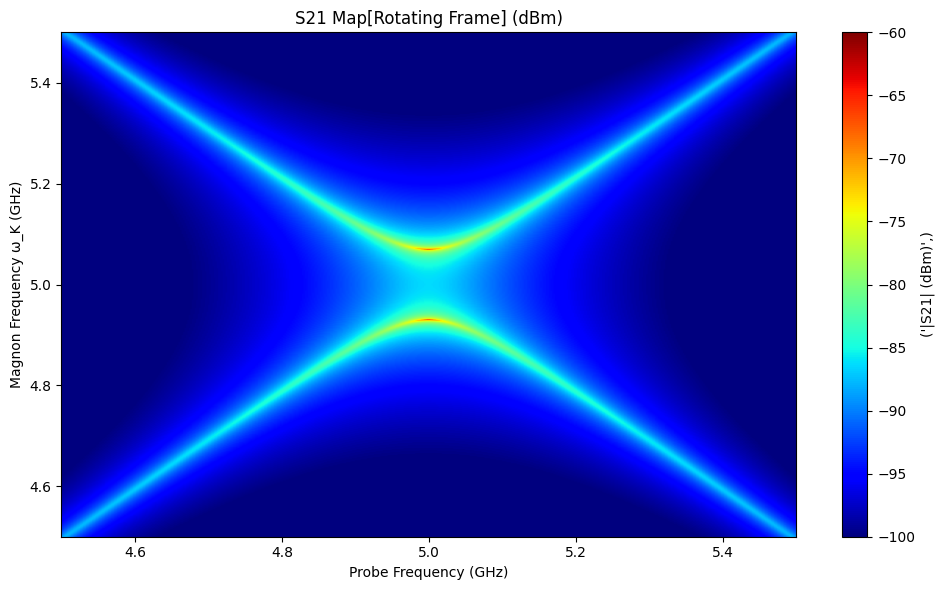

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve



def compute_S21_map(probe_freqs, detune_freqs, omega_c, omega_m, gamma_s, delta_m, Gamma_r, g_eff, phi, mode='dBm'):
    S21_map = []
    for d_omega in detune_freqs:
        S21_row = []
        for omega in probe_freqs:
            # 建立非 Hermitian Hamiltonian
            H = np.array([
                [omega_m -d_omega - 1j*(delta_m + Gamma_r), g_eff ],
                [g_eff * np.exp(-1j * phi), omega_c + d_omega - 1j*(gamma_s+delta_m)]
            ])
            A = H - omega * np.eye(2)
            b = np.array([0, 1.0])  # 輸入訊號從 cavity 側輸入

            x = solve(A, b)
            s21 =  x[0]  # 輸出訊號在 cavity port

            if mode == 'dBm':
                S21_row.append(10 * np.log10(np.abs(s21)))
            elif mode == 'linear':
                S21_row.append(np.abs(s21))
            elif mode == 'phase':
                S21_row.append(np.angle(s21))
            else:
                raise ValueError("Invalid mode. Choose from 'dBm', 'linear', or 'phase'.")
        S21_map.append(S21_row)
    return np.array(S21_map)

def plot_S21(S21_map, probe_freqs, qubit_freqs, mode='dBm'):
    plt.figure(figsize=(10, 6))
    extent = [probe_freqs[0]/1e9, probe_freqs[-1]/1e9,
              qubit_freqs[0]/1e9, qubit_freqs[-1]/1e9]
    label = {'dBm': '|S21| (dBm)', 'linear': '|S21|', 'phase': 'Phase (rad)'}[mode],
    plt.imshow(S21_map, aspect='auto', origin='lower', extent=extent, cmap='jet',vmax= -60, vmin= -100,)
    plt.colorbar(label=label)
    plt.xlabel('Probe Frequency (GHz)')
    plt.ylabel('Magnon Frequency ω_K (GHz)')
    plt.title(f'S21 Map[Rotating Frame] ({mode})')
    plt.tight_layout()
    plt.show()

# ====== 模擬參數 ======
omega_c = 2 * np.pi * 5e9      # cavity mode 頻率 (rad/s)
omega_m = 2 * np.pi * 5e9      # magnon 頻率 (rad/s)
gamma_s = 2 * np.pi * 5e6      # cavity 模式 linewidth
delta_m = 2 * np.pi * 2e6      # magnon 本徵 linewidth
Gamma_r = 2 * np.pi * 5e6      # traveling wave 對 magnon 的徑向損耗

# 有效耦合常數（可以調為正、負以模擬吸引或排斥）
phi = np.pi                       # 相位：0（排斥），π（吸引）
g_eff = 2 * np.pi * 70e6 * np.exp(1j * phi)      # 有效耦合強度

# 掃描頻率區間mode
mode = 'dBm'
probe_freqs = np.linspace(4.5e9, 5.5e9, 500)  # 探針頻率 ω
detune_freqs = np.linspace(-0.5e9, +0.5e9, 500)  # Δω
# ====== 模擬執行 ======
S21_map = compute_S21_map(probe_freqs * 2 * np.pi, detune_freqs * 2 * np.pi, omega_m,
                           omega_c, gamma_s, delta_m, Gamma_r, g_eff, phi, mode)
plot_S21(S21_map, probe_freqs, qubit_freqs, mode)


# 算eigenstate

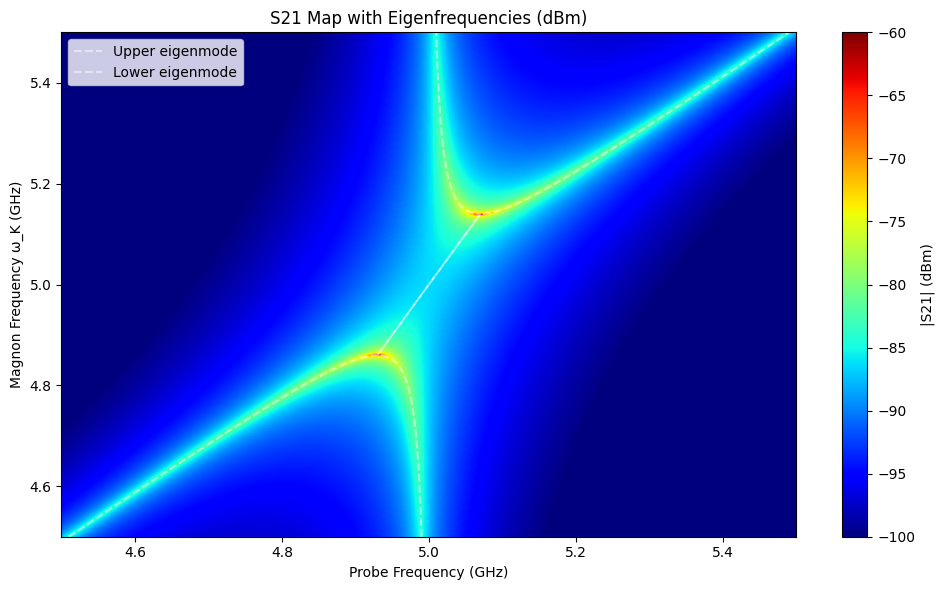

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve



def compute_S21_map(probe_freqs, qubit_freqs, omega_c, gamma_s, delta_m, Gamma_r, g_eff, phi, mode='dBm'):
    S21_map = []
    for omega_m in qubit_freqs:
        S21_row = []
        for omega in probe_freqs:
            # 建立非 Hermitian Hamiltonian
            H = np.array([
                [omega_m - 1j*(delta_m + Gamma_r), g_eff ],
                [g_eff * np.exp(-1j * phi), omega_c - 1j*(gamma_s+delta_m)]
            ])
            A = H - omega * np.eye(2)
            b = np.array([0, 1.0])  # 輸入訊號從 cavity 側輸入

            x = solve(A, b)
            s21 =  x[0]  # 輸出訊號在 cavity port

            if mode == 'dBm':
                S21_row.append(10 * np.log10(np.abs(s21)))
            elif mode == 'linear':
                S21_row.append(np.abs(s21))
            elif mode == 'phase':
                S21_row.append(np.angle(s21))
            else:
                raise ValueError("Invalid mode. Choose from 'dBm', 'linear', or 'phase'.")
        S21_map.append(S21_row)
    return np.array(S21_map)

def compute_eigenfrequencies(qubit_freqs, omega_c, gamma_s, delta_m, Gamma_r, g_eff, phi):
    eig_plus = []
    eig_minus = []
    for omega_m in qubit_freqs:
        H = np.array([
            [omega_m - 1j*(delta_m + Gamma_r), g_eff],
            [g_eff * np.exp(-1j * phi), omega_c - 1j*(gamma_s + delta_m)]
        ])
        eigvals = np.linalg.eigvals(H)
        eig_plus.append(np.max(np.real(eigvals)))   # 取較高頻那個模態
        eig_minus.append(np.min(np.real(eigvals)))  # 取較低頻那個模態
    return np.array(eig_plus), np.array(eig_minus)

def plot_S21(S21_map, probe_freqs, qubit_freqs, eig_plus=None, eig_minus=None, mode='dBm'):
    plt.figure(figsize=(10, 6))
    extent = [probe_freqs[0]/1e9, probe_freqs[-1]/1e9,
              qubit_freqs[0]/1e9, qubit_freqs[-1]/1e9]
    label = {'dBm': '|S21| (dBm)', 'linear': '|S21|', 'phase': 'Phase (rad)'}[mode]

    plt.imshow(S21_map, aspect='auto', origin='lower', extent=extent, cmap='jet', vmax= -60, vmin= -100)
    plt.colorbar(label=label)

    if eig_plus is not None and eig_minus is not None:
        plt.plot(eig_plus / (2*np.pi*1e9), qubit_freqs / 1e9, 'w--', alpha = 0.5, label='Upper eigenmode')
        plt.plot(eig_minus / (2*np.pi*1e9), qubit_freqs / 1e9, 'w--', alpha = 0.5, label='Lower eigenmode')
        plt.legend()

    plt.xlabel('Probe Frequency (GHz)')
    plt.ylabel('Magnon Frequency ω_K (GHz)')
    plt.title(f'S21 Map with Eigenfrequencies ({mode})')
    plt.tight_layout()
    plt.show()

# ====== 模擬參數 ======
omega_c = 2 * np.pi * 5e9      # cavity mode 頻率 (rad/s)
omega_m = 2 * np.pi * 5e9      # magnon 頻率 (rad/s)
gamma_s = 2 * np.pi * 5e6      # cavity 模式 linewidth
delta_m = 2 * np.pi * 2e6      # magnon 本徵 linewidth
Gamma_r = 2 * np.pi * 5e6      # traveling wave 對 magnon 的徑向損耗

# 有效耦合常數（可以調為正、負以模擬吸引或排斥）
phi = np.pi                       # 相位：0（排斥），π（吸引）
g_eff = 2 * np.pi * 70e6 * np.exp(1j * phi)      # 有效耦合強度

# 掃描頻率區間mode
mode = 'dBm'
probe_freqs = np.linspace(4.5e9, 5.5e9, 500)  # 探針頻率 ω
qubit_freqs = np.linspace(4.5e9, 5.5e9, 500)  # omega_k
# ====== 模擬執行 ======
S21_map = compute_S21_map(probe_freqs * 2 * np.pi, qubit_freqs * 2 * np.pi,
                           omega_c, gamma_s, delta_m, Gamma_r, g_eff, phi, mode)
eig_plus, eig_minus = compute_eigenfrequencies(qubit_freqs * 2 * np.pi,
                                               omega_c, gamma_s, delta_m, Gamma_r, g_eff, phi)

plot_S21(S21_map, probe_freqs, qubit_freqs, eig_plus, eig_minus, mode)



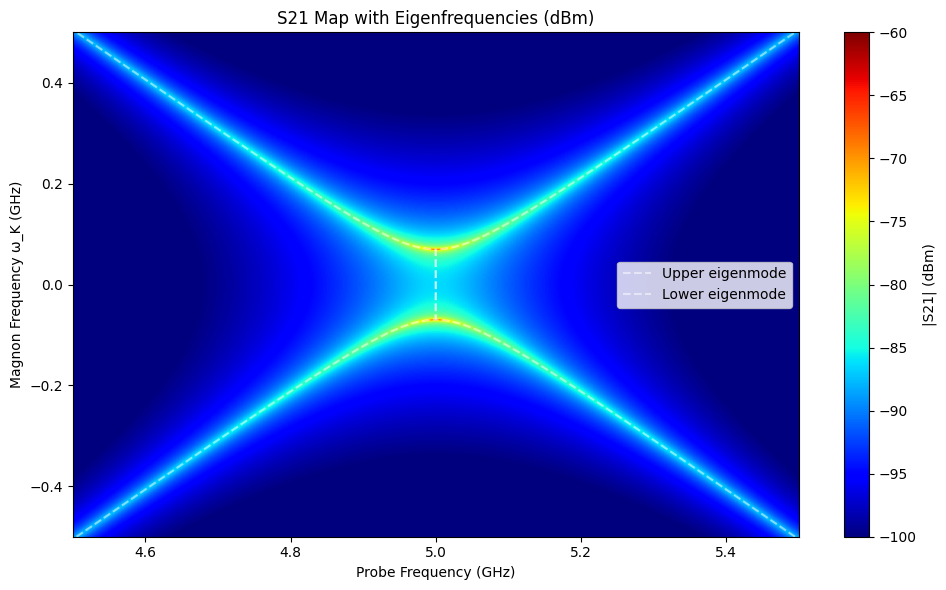

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve



def compute_S21_map(probe_freqs, qubit_freqs, omega_c, gamma_s, delta_m, Gamma_r, g_eff, phi, mode='dBm'):
    S21_map = []
    for d_omega in qubit_freqs:
        S21_row = []
        for omega in probe_freqs:
            # 建立非 Hermitian Hamiltonian
            H = np.array([
                [omega_m - d_omega- 1j*(delta_m + Gamma_r), g_eff ],
                [g_eff * np.exp(-1j * phi), omega_c + d_omega - 1j*(gamma_s+delta_m)]
            ])
            A = H - omega * np.eye(2)
            b = np.array([0, 1.0])  # 輸入訊號從 cavity 側輸入

            x = solve(A, b)
            s21 =  x[0]  # 輸出訊號在 cavity port

            if mode == 'dBm':
                S21_row.append(10 * np.log10(np.abs(s21)))
            elif mode == 'linear':
                S21_row.append(np.abs(s21))
            elif mode == 'phase':
                S21_row.append(np.angle(s21))
            else:
                raise ValueError("Invalid mode. Choose from 'dBm', 'linear', or 'phase'.")
        S21_map.append(S21_row)
    return np.array(S21_map)

def compute_eigenfrequencies(qubit_freqs, omega_c, gamma_s, delta_m, Gamma_r, g_eff, phi):
    eig_plus = []
    eig_minus = []
    for d_omega in qubit_freqs:
        H = np.array([
            [omega_m - d_omega- 1j*(delta_m + Gamma_r), g_eff ],
            [g_eff * np.exp(-1j * phi), omega_c + d_omega - 1j*(gamma_s+delta_m)]
        ])
        eigvals = np.linalg.eigvals(H)
        eig_plus.append(np.max(np.real(eigvals)))   # 取較高頻那個模態
        eig_minus.append(np.min(np.real(eigvals)))  # 取較低頻那個模態
    return np.array(eig_plus), np.array(eig_minus)

def plot_S21(S21_map, probe_freqs, qubit_freqs, eig_plus=None, eig_minus=None, mode='dBm'):
    plt.figure(figsize=(10, 6))
    extent = [probe_freqs[0]/1e9, probe_freqs[-1]/1e9,
              qubit_freqs[0]/1e9, qubit_freqs[-1]/1e9]
    label = {'dBm': '|S21| (dBm)', 'linear': '|S21|', 'phase': 'Phase (rad)'}[mode]

    plt.imshow(S21_map, aspect='auto', origin='lower', extent=extent, cmap='jet', vmax= -60, vmin= -100)
    plt.colorbar(label=label)

    if eig_plus is not None and eig_minus is not None:
        plt.plot(eig_plus / (2*np.pi*1e9), qubit_freqs / 1e9, 'w--', alpha = 0.5, label='Upper eigenmode')
        plt.plot(eig_minus / (2*np.pi*1e9), qubit_freqs / 1e9, 'w--', alpha = 0.5, label='Lower eigenmode')
        plt.legend()

    plt.xlabel('Probe Frequency (GHz)')
    plt.ylabel('Magnon Frequency ω_K (GHz)')
    plt.title(f'S21 Map with Eigenfrequencies ({mode})')
    plt.tight_layout()
    plt.show()

# ====== 模擬參數 ======
omega_c = 2 * np.pi * 5e9      # cavity mode 頻率 (rad/s)
omega_m = 2 * np.pi * 5e9      # magnon 頻率 (rad/s)
gamma_s = 2 * np.pi * 5e6      # cavity 模式 linewidth
delta_m = 2 * np.pi * 2e6      # magnon 本徵 linewidth
Gamma_r = 2 * np.pi * 5e6      # traveling wave 對 magnon 的徑向損耗

# 有效耦合常數（可以調為正、負以模擬吸引或排斥）
phi = np.pi                       # 相位：0（排斥），π（吸引）
g_eff = 2 * np.pi * 70e6 * np.exp(1j * phi)      # 有效耦合強度

# 掃描頻率區間mode
mode = 'dBm'
probe_freqs = np.linspace(4.5e9, 5.5e9, 500)  # 探針頻率 ω
qubit_freqs = np.linspace(-0.5e9, +.5e9, 500)  # omega_k
# ====== 模擬執行 ======
S21_map = compute_S21_map(probe_freqs * 2 * np.pi, qubit_freqs * 2 * np.pi,
                           omega_c, gamma_s, delta_m, Gamma_r, g_eff, phi, mode)
eig_plus, eig_minus = compute_eigenfrequencies(qubit_freqs * 2 * np.pi,
                                               omega_c, gamma_s, delta_m, Gamma_r, g_eff, phi)

plot_S21(S21_map, probe_freqs, qubit_freqs, eig_plus, eig_minus, mode)

